In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import string 
import re
import spacy
import warnings

pd.options.display.float_format = "{:.3f}".format 

warnings.filterwarnings('ignore')

In [76]:
books_names = ["boska-komedia", "dziady-cz-2", "dziady-cz-3", "kordian", "latarnik", "nie-boska-komedia", "potop"]
autorzy = ["Dante Alighieri", "Adam Mickiewicz", "Adam Mickiewicz ", "Juliusz Słowacki", "Stefan Żeromski", "Zygmunt Krasiński", "Henryk Sienkiewicz"]

In [3]:
def open_book(bookname):
    if not bookname.endswith(".txt"):
        bookname = bookname + ".txt"
    return open('books/' + str(bookname), mode='r', encoding='utf-8')

def load_stops(stopsfilename):
    stops = []
    with open(stopsfilename, mode='r') as stops_file:
        stops = stops_file.read().splitlines()
    return stops

stops = load_stops("stopyPL.txt")

In [4]:
# Funckje służące tokenizacji tesktów 

def remove_punctuation(string_to_remove):
    punc = string.punctuation + '—' + '.' + '...' + '„' + '”' + '…'
    string_to_remove = string_to_remove.translate(str.maketrans('', '', punc))
    return string_to_remove.replace(' ', '')
        
def strip_book_data(file, stopsarray=[]):
    stripped_data = []            
    for line in file:
        line_words = line.split()
        for word in line_words: 
            word = remove_punctuation(word.lower())
            if word and word not in stopsarray:
                stripped_data.append(word)

    return stripped_data

In [5]:
# funkcje lematyzacji
def lematyzuj(tokeny):
    lematyzator = spacy.load('pl_core_news_sm')
    wynik = []
    lematy = lematyzator(' '.join(tokeny))
    for l in lematy:
        wynik.append(l.lemma_)
    return wynik

In [6]:
# Tokenizacja tekstów - podział na poszczególne słowa z odrzuceniem znaków interpunkcyjnych oraz znaków stopu
books = dict()
for book_name in books_names:
    book_file = open_book(book_name)
    stripped_book_data = strip_book_data(book_file, stopsarray=stops)
    lematyzowany_tekst = lematyzuj(stripped_book_data)
    book_file.close()
    
    books[book_name] = lematyzowany_tekst

In [7]:
def count_word_freq(words):
    freq = {}
    for word in sorted(words):
        if word in freq.keys():
            freq[word] = freq[word] + 1
        else:
            freq[word] = 1
    return freq

def pokaz_czeste(slownik,prog):
    for klucz,wartosc in slownik.items():
        if wartosc>prog:
            print(klucz,":",wartosc)

In [8]:
books_freq = dict()
total_freq = dict()
total_text = []
for book_name in books_names:
    books_freq[book_name] = count_word_freq(books[book_name])
    total_text = total_text + books[book_name]
total_freq = count_word_freq(total_text)

print("Słowa w Kordianie: ", books['kordian'][90:110])
print("Częstość występowania słowa świst: ", books_freq['kordian']['miecz'])

Słowa w Kordianie:  ['polski', 'szabla', 'widzieć', 'diabl', 'odpowiadać', 'błysk', 'chmura', 'lecieć', 'świst', 'pióro', 'buka', 'ugina', 'szatan', 'zlatować', 'postać', 'piękny', 'anioł', 'szatan', 'hektar', 'czarownico']
Częstość występowania słowa świst:  12


In [9]:
# term document matrix
def tdmPT(slownik,prog_czestosci):
    nazwy_czesci = books_names
    tdm = pd.DataFrame(columns=nazwy_czesci)
    for slowo,ile_razy in slownik.items():
        if ile_razy > prog_czestosci:
            licznik = [0]*len(nazwy_czesci)
            for i in range(0,len(nazwy_czesci)):
                for token in books[nazwy_czesci[i]]:
                    if slowo == token:
                        licznik[i] = licznik[i] + 1   
            element = pd.DataFrame([licznik], columns=nazwy_czesci, index = [slowo])
            tdm = tdm.append(element)
    return tdm

# tf-idf
def policz_tfidf(tdm):
    ile_ksiazek = tdm.shape[1]
    ile_slow = tdm.count(0)[0]
    tf = np.empty((ile_slow,ile_ksiazek))
    for i in range(0,ile_ksiazek):
        tf[:,i] = np.array(tdm.iloc[:,i]/tdm.sum()[i])
    idf = np.log(ile_ksiazek/np.array((tdm>0)*1).sum(axis=1))
    tfidf = pd.DataFrame((tf*np.array([idf,]*ile_ksiazek).T*100), columns=tdm.columns, index = tdm.index)
    tfidf["w_ilu"] = (np.array((tdm>0)*1).sum(axis=1)).T
    tfidf["idf"] = idf.T
    return tfidf

In [10]:
matrix1 = tdmPT(total_freq, 20);

In [11]:
tfidf = policz_tfidf(matrix1)
tfidf

,boska-komedia,dziady-cz-2,dziady-cz-3,kordian,latarnik,nie-boska-komedia,potop,w_ilu,idf
Andrzej,0.000,0.000,0.000,0.000,0.000,0.000,0.454,1,1.946
Bogusław,0.000,0.000,0.000,0.000,0.000,0.000,0.138,1,1.946
Dante,2.416,0.000,0.000,0.000,0.000,0.000,0.000,1,1.946
Jan,0.032,0.000,0.000,0.008,0.000,0.009,0.034,4,0.560
Jezus,0.000,0.000,0.071,0.031,0.000,0.035,0.009,4,0.560
...,...,...,...,...,...,...,...,...,...
żołnierz,0.004,0.000,0.020,0.061,0.035,0.017,0.064,6,0.154
życie,0.000,0.000,0.000,0.000,0.000,0.000,0.000,7,0.000
żywo,0.000,0.000,0.000,0.000,0.000,0.000,0.130,1,1.946
żywy,0.058,0.000,0.033,0.009,0.000,0.026,0.018,5,0.336


In [12]:
#funkcja do liczenia odleglosci

def odleglosc(x, y, typ = 'kosinusowa'):
    if typ == 'kosinusowa':
        return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))
    elif typ == 'Euklidesowa':
        return np.sqrt(np.sum((x - y) ** 2))
    else: # miejska
        return np.sum(np.abs(x - y))

<AxesSubplot:>

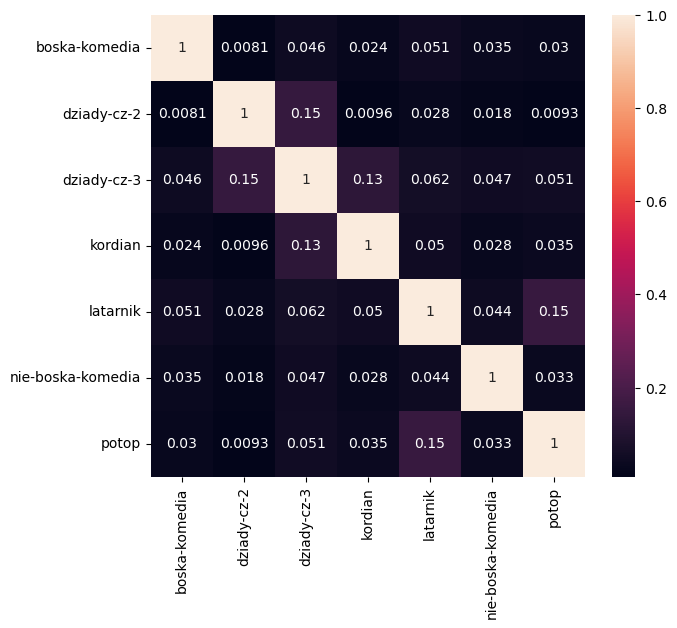

In [56]:
# podobienstwo tekstow

czestosc_odciecia = 30
ilosc_tytulow = len(books_names)

tdm = tdmPT(total_freq,czestosc_odciecia)
tfidf = policz_tfidf(tdm)
mac_odl = np.empty([ilosc_tytulow, ilosc_tytulow])
for i in range(0,ilosc_tytulow):
    for j in range(0,ilosc_tytulow):
        mac_odl[i,j] = odleglosc(tfidf.iloc[:,i],tfidf.iloc[:,j])
plt.figure(figsize=(7,6),dpi = 100)
sns.heatmap(mac_odl,annot = mac_odl, xticklabels=books_names, yticklabels=books_names)

In [89]:
# funkcje

def read_books_raw(books_names: []) -> []:
    dane = []
    for name in books_names:
        file = open_book(name)
        dane.append(file.read())
    return dane

def generuj_dane_z_fragmentami_tytuly() -> dict:
    fragmenty_tesktow_tytuly = {
        books_names[0] : "Dante przez lata następne tułał się po rozmaitych miastach włoskich, obnosząc i pokazując wszystkim, jak sam się wyraża, rany swego serca. Lecz w tej ciernistej wędrówce tułaczej podtrzymywały jego siłę moralną nauka i praca, te dwie ziemskie pocieszycielki dusz wielkich a nieszczęśliwych! W tym przeciągu czasu poświęcił się nauce teologii i filozofii. Z żelazną wolą naginając się do różnostronnej pracy, pisał zarazem swoją nieśmiertelną komedię. Była to stała i nierozdzielna towarzyszka jego wygnania. Gdy jej część pierwsza pod napisem: Piekło, szybko rozleciała się po całych Włoszech, odtąd popularność Dantego jako poety rosła bez końca. Lud włoski widząc po raz pierwszy objawionych tyle wzniosłych myśli i obrazów w swoim języku, sam język przez poetę uszlachetniony i podniesiony do najwyższej potęgi słowa i formy poetycznej, chciwie chwytał, przepisywał i uczył się na pamięć wierszy poety, deklamując je po rynkach i ulicach miast swoich. Przerażające obrazy kręgów piekielnych, nakreślone mistrzowskim piórem poety, zapalały żywą i wrażliwą imaginację ludu włoskiego; widział on w tych obrazach kar pozaświatowych odtworzony obraz ziemskiej anarchii demagogicznej, jaka jego miasta i rzeczpospolite wichrzyła. Dante dla ludu włoskiego staje się istotą pośrednią między człowiekiem a duchem; on wie, co się dzieje w piekle, wszystkich potępieńców umarłych, a nawet żyjących zna po imieniu. I tak: gdy poeta chce wywrzeć zemstę na trzech florentczykach, najzaciętszych swych wrogach, nie zabija ich; lecz w swoich wierszach powiada, że ci trzej byli umarli, że ich sam widział w piekle, i że ich ciała na ziemi żyją tylko pozornym życiem ożywionym przez szatanów. Ogromna była popularność i potęga geniusza Dantego, jaką na lud włoski wywierał. Żywe świadectwa tej popularnej potęgi czasami słyszał poeta z ust żyjących nie bez wewnętrznej pociechy. W Weronie przechodząc wedle bramy miejskiej, przy której na ławie siedziały kobiety, posłyszał jak jedna z nich mówiła cicho do sąsiadki: „Patrz, oto człowiek, który kiedy chce zstępuje do piekła i zeń powraca i przynosi wieści na ziemię o potępieńcach”; a druga na to: „Zaiste, co mówisz, powinno być prawdą; czy widzisz, jaką on ma brodę kędzierzawą, a cerę smagłą sczerniałą, jest to ogień i dym piekielny”. Słysząc to Dante, jak mówi Bokacjusz, uśmiechnął się i poszedł dalej.",
        books_names[1] : "GUŚLARZ\nCzas odemknąć drzwi kaplicy.\nZapalcie lampy i świécy.\nPrzeszła północ, kogut pieje,\nSkończona straszna ofiara,\nCzas przypomnieć ojców dzieje.\nStójcie…",
        books_names[2] : "KAPRAL\n\nOszaleć? — Ej, Panowie, strzeżcie się, Panowie!\nU was usta wymowne, wiele nauk w głowie,\nA patrzcie, głowa mądra w prochu się taczała,\nI z tych ust, tak wymownych, patrzaj — piana biała.\nSłyszałem, co on śpiewał, ja słów nie pojąłem,\nLecz było coś u niego w oczach i nad czołem.\nWierz mi, że z tym człowiekiem niedobrze się dzieje —\nByłem ja w legijonach, nim wzięto w rekruty,\nBrałem szturmem fortece, klasztory, reduty;\nWięcej dusz wychodzących z ciała ja widziałem,\nNiźli Waćpan przeczytał książek w życiu całem.\nA to jest rzecz niemała widzieć, jak człek kona.\nWidziałem ja na Pradze księży zarzynanych,\nI w Hiszpaniji żywcem z wieży wyrzucanych;\nWidziałem matek szablą rozrywane łona,\nI dzieci konające na kozackich pikach,\nI Francuzów na śniegu, i Turków na palu;\nI wiem, co w konających widać męczennikach,\nA co w złodzieju, zbójcy, Turku lub Moskalu.\nWidziałem rozstrzelanych, co patrzyli śmiele\nW rurę broni, nie chcieli na oczy zasłony;\nA jak padli na ziemię, widziałem w ich ciele\nStrach, co za życia wstydem i pychą więziony,\nWyszedł z trupa jak owad i pełzał wokoło:",
        books_names[3] : "KSIĄDZ\n\nCoż powie głos z mównicy? gdy ciało mocarza,\nKtóry swym berłem trony Europy podważa,\nWśród kadzidł, świec jarzących na katafalk wniosą,\nO ludy! ludy! płaczcie łez rzęsistą rosą\nI za ziemię Lechitów w prochy bijcie czołem,\nI posypujcie czoła prochem i popiołem,\nBo ta ziemia Jaheli uzbrojona ćwiekiem,\nNiegodnie…",
        books_names[4] : "Pewnego razu, gdy łódź przywiozła wodę i zapasy żywności, Skawiński, zeszedłszy w godzinę później z wieży, spostrzegł, że prócz zwykłego ładunku jest jeszcze jedna paczka więcej. Na wierzchu paczki były marki pocztowe Stanów Zjednoczonych i wyraźny adres „Skawiński Esq.”, wypisany na grubym żaglowym płótnie. Rozciekawiony starzec przeciął płótno i ujrzał książki: wziął jedną do ręki, spojrzał i położył na powrót, przy czym ręce poczęły mu drżeć mocno. Przysłonił oczy, jakby im nie wierząc; zdawało mu się, że śni — książka była polska. Co to miało znaczyć?! Kto mu mógł przysłać książkę? W pierwszej chwili zapomniał widocznie, iż jeszcze na początku swej latarniczej kariery przeczytał pewnego razu w pożyczonym od konsula »Heraldzie« o zawiązaniu polskiego Towarzystwa w New Yorku i że zaraz przesłał Towarzystwu połowę swej miesięcznej pensji, z którą zresztą nie miał co robić na wieży. Towarzystwo wywdzięczając się przysyłało książki. Przyszły one drogą naturalną, ale w pierwszej chwili starzec nie mógł pochwytać tych myśli. Polskie książki w Aspinwall, na jego wieży, wśród jego samotności, była to dla niego jakaś nadzwyczajność, jakieś tchnienie dawnych czasów, cud jakiś. Teraz wydało mu się, jak owym żeglarzom wśród nocy, że coś zawołało na niego po imieniu głosem bardzo kochanym, a zapomnianym prawie. Przesiedział chwilę z zamkniętymi oczyma i był prawie pewny, że gdy je otworzy, sen zniknie. Nie! Rozcięta paczka leżała przed nim wyraźnie, oświecona blaskiem popołudniowego słońca, a na niej otwarta już książka. Gdy stary wyciągnął znowu po nią rękę, słyszał wśród ciszy bicie własnego serca. Spojrzał: były to wiersze. Na wierzchu stał wypisany wielkimi literami tytuł, pod spodem zaś imię autora. Imię to nie było Skawińskiemu obce; wiedział, że należy ono do wielkiego poety, którego nawet i utwory czytywał po trzydziestym roku w Paryżu. Potem, wojując w Algerze i w Hiszpanii, słyszał od rodaków o coraz wzrastającej sławie wielkiego wieszcza, ale tak przywykł wówczas do karabina, że i do ręki nie brał książek. W czterdziestym dziewiątym roku wyjechał do Ameryki i w awanturniczym życiu, jakie prowadził, prawie nie spotykał Polaków, a nigdy książek polskich.",
        books_names[5] : "MĄŻ\n\nWidzę go znowu — drugie niewiasty cisną się za nim, blade, obłąkane, w konwulsjach. — Syn filozofa pieni się, potrząsa sztyletem. — Dochodzą teraz do ruin wieży północnej. —\n\nStanęli — pląsają na gruzach — rozrywają nieobalone arkady — sypią iskrami na leżące ołtarze i krzyże — płomień się zajmuje i gna słupy dymu przed sobą — biada wam — biada! —",
        books_names[6] : "To rzekłszy, książę wyciągnął obie ręce do góry, jakby naprawdę chciał podeprzeć walące się sklepienia, i było w nim coś tak olbrzymiego, że Kmicic otworzył szeroko oczy i patrzył nań, i jakby nigdy dotąd nie widział — a na koniec spytał zmienionym głosem:\n\n— Dokąd wasza książęca mość dążysz?… Czego chesz?…\n\n— Chcę… korony! — zakrzyknął Radziwiłł.\n\n— Jezus Maria!…\n\nNastała chwila głuchej ciszy — jeno puszczyk na wieży zamkowej począł się śmiać przeraźliwie.\n\n— Słuchaj — rzekł książę — czas powiedzieć ci wszystko… Rzeczpospolita ginie… i zginąć musi. Nie masz dla niej na ziemi ratunku. Chodzi o to, by naprzód ten kraj, tę naszą ojczyznę bliższą, ocalić z rozbicia… a potem… potem wszystko odrodzić z popiołów, jako się feniks odradza… Ja to uczynię… i tę koronę, której chcę, włożę jako ciężar na głowę, by z onej wielkiej mogiły żywot nowy wyprowadzić… Nie drżyj! ziemia się nie rozpada, wszystko stoi na dawnym miejscu, jeno czasy nowe przychodzą… Oddałem ten kraj Szwedom, aby ich orężem drugiego nieprzyjaciela pohamować, wyżenąć go z granic, odzyskać, co stracone, i w jego własnej stolicy mieczem traktat wymusić… Słyszysz ty mnie? Ale w onej skalistej, głodnej Szwecji nie masz dość ludzi, dość sił, dość szabel, aby tę niezmierną Rzeczpospolitą zagarnąć. Mogą zwyciężyć raz i drugi nasze wojsko; utrzymać nas w posłuszeństwie nie zdołają… Gdyby każdym dziesięciu ludziom tutejszym dodać za strażnika jednego Szweda, jeszcze by dla wielu dziesiątków strażników nie stało… I Karol Gustaw wie o tym dobrze, i nie chce, i nie może zagarnąć całej Rzeczypospolitej… Zajmie Prusy Królewskie, część Wielkopolski co najwięcej — i tym się będzie kontentował. Ale aby owymi nabytkami mógł na przyszłe czasy bezpiecznie władnąć, musi sojusz Korony z nami rozerwać, bo inaczej nie osiedziałby się w tamtych prowincjach. Cóż się więc stanie z tym krajem? Komu go oddadzą? Oto, jeśli ja odrzucę tę koronę, którą mi Bóg i fortuna na głowę kładą, tedy oddadzą go temu, kto go w tej chwili istotnie opanował… Lecz Karol Gustaw nierad tego czynić, by sąsiedzkiej potęgi zbytnio nie utuczyć i groźnego sobie nieprzyjaciela nie stworzyć. Chyba, że ja koronę odrzucę, wówczas musi tak być… Zali więc mam prawo ją odrzucać? Zali mogę pozwolić, aby stało się to, co ostatnią zgubą grozi? Po raz dziesiąty i setny pytam: gdzie inny środek ratunku? Niech się więc dzieje wola boża! Biorę ten ciężar na ramiona. Szwedzi są za mną, elektor, nasz krewny, pomoc przyrzeka. Uwolnię kraj od wojny! Od zwycięstw i rozszerzenia granic rozpocznę panowanie domu mego. Zakwitnie spokój i pomyślność, ogień nie będzie palił wsi i miast. Tak będzie i tak być musi… Tak mi dopomóż Bóg i święty Krzyż — bo czuję w sobie siłę i moc z nieba mi daną, bo chcę szczęścia tej krainy, bo nie tu jeszcze koniec moich zamysłów… I na te światła niebieskie przysięgam, na te drgające gwiazdy, że niech jeno sił i zdrowia mi starczy, a cały ten gmach walący się dzisiaj odbuduję na nowo i potężniejszym niż dotąd go uczynię."
    }
    
    return fragmenty_tesktow_tytuly
    
def generuj_dane_z_fragmentami_autorzy() -> dict:
    fragmenty_tesktow_autorzy = {
        autorzy[0] : "Dante przez lata następne tułał się po rozmaitych miastach włoskich, obnosząc i pokazując wszystkim, jak sam się wyraża, rany swego serca. Lecz w tej ciernistej wędrówce tułaczej podtrzymywały jego siłę moralną nauka i praca, te dwie ziemskie pocieszycielki dusz wielkich a nieszczęśliwych! W tym przeciągu czasu poświęcił się nauce teologii i filozofii. Z żelazną wolą naginając się do różnostronnej pracy, pisał zarazem swoją nieśmiertelną komedię. Była to stała i nierozdzielna towarzyszka jego wygnania. Gdy jej część pierwsza pod napisem: Piekło, szybko rozleciała się po całych Włoszech, odtąd popularność Dantego jako poety rosła bez końca. Lud włoski widząc po raz pierwszy objawionych tyle wzniosłych myśli i obrazów w swoim języku, sam język przez poetę uszlachetniony i podniesiony do najwyższej potęgi słowa i formy poetycznej, chciwie chwytał, przepisywał i uczył się na pamięć wierszy poety, deklamując je po rynkach i ulicach miast swoich. Przerażające obrazy kręgów piekielnych, nakreślone mistrzowskim piórem poety, zapalały żywą i wrażliwą imaginację ludu włoskiego; widział on w tych obrazach kar pozaświatowych odtworzony obraz ziemskiej anarchii demagogicznej, jaka jego miasta i rzeczpospolite wichrzyła. Dante dla ludu włoskiego staje się istotą pośrednią między człowiekiem a duchem; on wie, co się dzieje w piekle, wszystkich potępieńców umarłych, a nawet żyjących zna po imieniu. I tak: gdy poeta chce wywrzeć zemstę na trzech florentczykach, najzaciętszych swych wrogach, nie zabija ich; lecz w swoich wierszach powiada, że ci trzej byli umarli, że ich sam widział w piekle, i że ich ciała na ziemi żyją tylko pozornym życiem ożywionym przez szatanów. Ogromna była popularność i potęga geniusza Dantego, jaką na lud włoski wywierał. Żywe świadectwa tej popularnej potęgi czasami słyszał poeta z ust żyjących nie bez wewnętrznej pociechy. W Weronie przechodząc wedle bramy miejskiej, przy której na ławie siedziały kobiety, posłyszał jak jedna z nich mówiła cicho do sąsiadki: „Patrz, oto człowiek, który kiedy chce zstępuje do piekła i zeń powraca i przynosi wieści na ziemię o potępieńcach”; a druga na to: „Zaiste, co mówisz, powinno być prawdą; czy widzisz, jaką on ma brodę kędzierzawą, a cerę smagłą sczerniałą, jest to ogień i dym piekielny”. Słysząc to Dante, jak mówi Bokacjusz, uśmiechnął się i poszedł dalej.",
        autorzy[1] : "GUŚLARZ\nCzas odemknąć drzwi kaplicy.\nZapalcie lampy i świécy.\nPrzeszła północ, kogut pieje,\nSkończona straszna ofiara,\nCzas przypomnieć ojców dzieje.\nStójcie…",
        autorzy[2] : "KAPRAL\n\nOszaleć? — Ej, Panowie, strzeżcie się, Panowie!\nU was usta wymowne, wiele nauk w głowie,\nA patrzcie, głowa mądra w prochu się taczała,\nI z tych ust, tak wymownych, patrzaj — piana biała.\nSłyszałem, co on śpiewał, ja słów nie pojąłem,\nLecz było coś u niego w oczach i nad czołem.\nWierz mi, że z tym człowiekiem niedobrze się dzieje —\nByłem ja w legijonach, nim wzięto w rekruty,\nBrałem szturmem fortece, klasztory, reduty;\nWięcej dusz wychodzących z ciała ja widziałem,\nNiźli Waćpan przeczytał książek w życiu całem.\nA to jest rzecz niemała widzieć, jak człek kona.\nWidziałem ja na Pradze księży zarzynanych,\nI w Hiszpaniji żywcem z wieży wyrzucanych;\nWidziałem matek szablą rozrywane łona,\nI dzieci konające na kozackich pikach,\nI Francuzów na śniegu, i Turków na palu;\nI wiem, co w konających widać męczennikach,\nA co w złodzieju, zbójcy, Turku lub Moskalu.\nWidziałem rozstrzelanych, co patrzyli śmiele\nW rurę broni, nie chcieli na oczy zasłony;\nA jak padli na ziemię, widziałem w ich ciele\nStrach, co za życia wstydem i pychą więziony,\nWyszedł z trupa jak owad i pełzał wokoło:",
        autorzy[3] : "KSIĄDZ\n\nCoż powie głos z mównicy? gdy ciało mocarza,\nKtóry swym berłem trony Europy podważa,\nWśród kadzidł, świec jarzących na katafalk wniosą,\nO ludy! ludy! płaczcie łez rzęsistą rosą\nI za ziemię Lechitów w prochy bijcie czołem,\nI posypujcie czoła prochem i popiołem,\nBo ta ziemia Jaheli uzbrojona ćwiekiem,\nNiegodnie…",
        autorzy[4] : "Pewnego razu, gdy łódź przywiozła wodę i zapasy żywności, Skawiński, zeszedłszy w godzinę później z wieży, spostrzegł, że prócz zwykłego ładunku jest jeszcze jedna paczka więcej. Na wierzchu paczki były marki pocztowe Stanów Zjednoczonych i wyraźny adres „Skawiński Esq.”, wypisany na grubym żaglowym płótnie. Rozciekawiony starzec przeciął płótno i ujrzał książki: wziął jedną do ręki, spojrzał i położył na powrót, przy czym ręce poczęły mu drżeć mocno. Przysłonił oczy, jakby im nie wierząc; zdawało mu się, że śni — książka była polska. Co to miało znaczyć?! Kto mu mógł przysłać książkę? W pierwszej chwili zapomniał widocznie, iż jeszcze na początku swej latarniczej kariery przeczytał pewnego razu w pożyczonym od konsula »Heraldzie« o zawiązaniu polskiego Towarzystwa w New Yorku i że zaraz przesłał Towarzystwu połowę swej miesięcznej pensji, z którą zresztą nie miał co robić na wieży. Towarzystwo wywdzięczając się przysyłało książki. Przyszły one drogą naturalną, ale w pierwszej chwili starzec nie mógł pochwytać tych myśli. Polskie książki w Aspinwall, na jego wieży, wśród jego samotności, była to dla niego jakaś nadzwyczajność, jakieś tchnienie dawnych czasów, cud jakiś. Teraz wydało mu się, jak owym żeglarzom wśród nocy, że coś zawołało na niego po imieniu głosem bardzo kochanym, a zapomnianym prawie. Przesiedział chwilę z zamkniętymi oczyma i był prawie pewny, że gdy je otworzy, sen zniknie. Nie! Rozcięta paczka leżała przed nim wyraźnie, oświecona blaskiem popołudniowego słońca, a na niej otwarta już książka. Gdy stary wyciągnął znowu po nią rękę, słyszał wśród ciszy bicie własnego serca. Spojrzał: były to wiersze. Na wierzchu stał wypisany wielkimi literami tytuł, pod spodem zaś imię autora. Imię to nie było Skawińskiemu obce; wiedział, że należy ono do wielkiego poety, którego nawet i utwory czytywał po trzydziestym roku w Paryżu. Potem, wojując w Algerze i w Hiszpanii, słyszał od rodaków o coraz wzrastającej sławie wielkiego wieszcza, ale tak przywykł wówczas do karabina, że i do ręki nie brał książek. W czterdziestym dziewiątym roku wyjechał do Ameryki i w awanturniczym życiu, jakie prowadził, prawie nie spotykał Polaków, a nigdy książek polskich.",
        autorzy[5] : "MĄŻ\n\nWidzę go znowu — drugie niewiasty cisną się za nim, blade, obłąkane, w konwulsjach. — Syn filozofa pieni się, potrząsa sztyletem. — Dochodzą teraz do ruin wieży północnej. —\n\nStanęli — pląsają na gruzach — rozrywają nieobalone arkady — sypią iskrami na leżące ołtarze i krzyże — płomień się zajmuje i gna słupy dymu przed sobą — biada wam — biada! —",
        autorzy[6] : "To rzekłszy, książę wyciągnął obie ręce do góry, jakby naprawdę chciał podeprzeć walące się sklepienia, i było w nim coś tak olbrzymiego, że Kmicic otworzył szeroko oczy i patrzył nań, i jakby nigdy dotąd nie widział — a na koniec spytał zmienionym głosem:\n\n— Dokąd wasza książęca mość dążysz?… Czego chesz?…\n\n— Chcę… korony! — zakrzyknął Radziwiłł.\n\n— Jezus Maria!…\n\nNastała chwila głuchej ciszy — jeno puszczyk na wieży zamkowej począł się śmiać przeraźliwie.\n\n— Słuchaj — rzekł książę — czas powiedzieć ci wszystko… Rzeczpospolita ginie… i zginąć musi. Nie masz dla niej na ziemi ratunku. Chodzi o to, by naprzód ten kraj, tę naszą ojczyznę bliższą, ocalić z rozbicia… a potem… potem wszystko odrodzić z popiołów, jako się feniks odradza… Ja to uczynię… i tę koronę, której chcę, włożę jako ciężar na głowę, by z onej wielkiej mogiły żywot nowy wyprowadzić… Nie drżyj! ziemia się nie rozpada, wszystko stoi na dawnym miejscu, jeno czasy nowe przychodzą… Oddałem ten kraj Szwedom, aby ich orężem drugiego nieprzyjaciela pohamować, wyżenąć go z granic, odzyskać, co stracone, i w jego własnej stolicy mieczem traktat wymusić… Słyszysz ty mnie? Ale w onej skalistej, głodnej Szwecji nie masz dość ludzi, dość sił, dość szabel, aby tę niezmierną Rzeczpospolitą zagarnąć. Mogą zwyciężyć raz i drugi nasze wojsko; utrzymać nas w posłuszeństwie nie zdołają… Gdyby każdym dziesięciu ludziom tutejszym dodać za strażnika jednego Szweda, jeszcze by dla wielu dziesiątków strażników nie stało… I Karol Gustaw wie o tym dobrze, i nie chce, i nie może zagarnąć całej Rzeczypospolitej… Zajmie Prusy Królewskie, część Wielkopolski co najwięcej — i tym się będzie kontentował. Ale aby owymi nabytkami mógł na przyszłe czasy bezpiecznie władnąć, musi sojusz Korony z nami rozerwać, bo inaczej nie osiedziałby się w tamtych prowincjach. Cóż się więc stanie z tym krajem? Komu go oddadzą? Oto, jeśli ja odrzucę tę koronę, którą mi Bóg i fortuna na głowę kładą, tedy oddadzą go temu, kto go w tej chwili istotnie opanował… Lecz Karol Gustaw nierad tego czynić, by sąsiedzkiej potęgi zbytnio nie utuczyć i groźnego sobie nieprzyjaciela nie stworzyć. Chyba, że ja koronę odrzucę, wówczas musi tak być… Zali więc mam prawo ją odrzucać? Zali mogę pozwolić, aby stało się to, co ostatnią zgubą grozi? Po raz dziesiąty i setny pytam: gdzie inny środek ratunku? Niech się więc dzieje wola boża! Biorę ten ciężar na ramiona. Szwedzi są za mną, elektor, nasz krewny, pomoc przyrzeka. Uwolnię kraj od wojny! Od zwycięstw i rozszerzenia granic rozpocznę panowanie domu mego. Zakwitnie spokój i pomyślność, ogień nie będzie palił wsi i miast. Tak będzie i tak być musi… Tak mi dopomóż Bóg i święty Krzyż — bo czuję w sobie siłę i moc z nieba mi daną, bo chcę szczęścia tej krainy, bo nie tu jeszcze koniec moich zamysłów… I na te światła niebieskie przysięgam, na te drgające gwiazdy, że niech jeno sił i zdrowia mi starczy, a cały ten gmach walący się dzisiaj odbuduję na nowo i potężniejszym niż dotąd go uczynię."
    }
    
    return fragmenty_tesktow_autorzy
    
def generuj_dane_z_fragmentami_autorzy_inne_ksiazki() -> dict:
    fragmenty_tesktow_autorzy = {
        autorzy[0]: "Właśnie tam, gdzie się zaczyna piekło, tam też jest miejsce, gdzie skargi słychać, jakie skarżą się na niesprawiedliwość Bożą, jakie w duszy noszą, tak że wiecznie wybuchają",
        autorzy[1]: "Litwo, Ojczyzno moja! ty jesteś jak zdrowie; Ile cię trzeba cenić, ten tylko się dowie, Kto cię stracił. Dziś piękność twą w całej ozdobie Widzą oczy moje i serce moje.",
        autorzy[2]: "Jakiś tekst Mickiewicza",
        autorzy[3]: "Podobne barwie róż, które świeciło\nW moim pałacu szklistym? czy też prawdziwe\nRóże na jego licach śmiercią mdlejące;\nAle się piękny wydał — ach! piękny tak, że chciałam\nZatrzymać go na wieki w zimnych pałacach,\nI nie rozwiązać z wieńca ramion, i przykuć\nŁańcuchem pocałunków. Wtem zaczął konać…\nMusiałam wtenczas, ach! musiałam go wypuścić!\nGdybym przynajmniej mogła była go wynieść\nZ wody na rękach moich, usta z ustami\nSpoić i życie wlać w ostygłe jego piersi;\nAle ty wiesz, co to za męka dla nas,\nKiedy, podobne kwiatom, musiemy składać\nRumieniec nasz i piękne barwy wiosny,\nI do kamieni białych podobne leżyć\nW głębiach jeziora. Taką ja wtenczas byłam.\nMusiałam leżeć na dnie, ani się płocho \nNa światło dnia wyrywać. Na pół martwego\nWyniosłam drzącą ręką i przez otwory\nW lodzie wybite rzucam: sama boleśnie",
        autorzy[4]: "Ludzie ziemi, ci co zawsze szli za ciosem, ci co zawsze byli za ciosem, ci co zawsze będą za ciosem, ci co zawsze będą ciosem.",
        autorzy[5]: "Wszystkim ciało dał Jehowa -\n\nDuszę wszystkim Chrystus dał,\n\nA Duch Święty żywot chowa,\n\nBy wraz ciało z duszą zlał!\n\n \n\nJa wam mówię - niedaleki\n\nZbawiciela Objawiciel!\n\nNiedaleki - nam przed wieki\n\nObiecany Pocieszyciel!\n\n \n\nOto idzie już godzina!\n\nPoznan będzie - niepojęty!\n\nZ Ojca weźmie, weźmie z Syna\n\nI rozleje się Duch Święty! -\n\n \n\nA nie trony - ni korony\n\nPierwsze ujrzą Cię na niebie -\n\nLecz niewinnie umęczony,\n\nTen, o Duchu, ujrzy Ciebie!\n\n \n\nKto lat tysiąc wieku strawił,\n\nKościół broniąc od poddaństwa!\n\nMilionową pierś wciąż krwawił,\n\nAż rozdeptał gad pogaństwa!\n\n \n\nKto śród ludów nie miał brata,\n\nTen, na czyim już pogrzebie\n\nByły wszystkie króle świata,\n\nTen, o, pierwszy ujrzy Ciebie!\n\n \n\nBo - choć krwawy, choć zemdlony,\n\nWzrok utopion trzyma w niebie!\n\nA kto patrzy w ducha strony,\n\nTen, o Duchu, ujrzy Ciebie! -",
        autorzy[6]: "Na północ od wybrzeża, daleko na północ, leżała pustynia, która przedstawiała jedną z najpiękniejszych i najdziwniejszych krain na świecie. Na południu rozciągała się dzika puszcza, która była jeszcze bardziej dzika i bardziej niebezpieczna niż pustynia. Pomiędzy nimi, na skraju pustyni i puszczy, znajdował się mały fort, który był jedynym schronieniem dla tych, którzy przemierzali te dzikie i niebezpieczne kraje. W fortem tym mieszkał młody chłopak imieniem Jan, który był synem dowódcy fortu. Jan był bardzo odważny i bardzo silny, a jego marzeniem było zwiedzenie pustyni i puszczy, które leżały daleko poza fortem. "
}

    
    return fragmenty_tesktow_autorzy

def create_w_and_s(data):
    w = CountVectorizer()
    s = np.array(w.fit_transform(teksty).todense())
    s.shape
    return w, s

def o_czym_jest_tekst(tekst: str, lista_hasel: [], typ_odleglosci: str = 'kosinusowa', display_limit = 100) -> str:
    x = np.array(w.transform([tekst]).todense())[0]
    max_odleglosc = 0
    max_haslo = ""
    for i in range(0,len(lista_hasel)):
        if odleglosc(x,s[i],typ_odleglosci) > max_odleglosc:
            max_odleglosc = odleglosc(x,s[i],typ_odleglosci)
            max_haslo = lista_hasel[i] 
        
    print("Tekst:\n\"%s(...)\" \n----> %s" % (tekst[:display_limit], max_haslo.upper()))
    
    return max_haslo

def sprawdz_ile_tytulow_rozpoznano_po_fragmentach(fragmenty_tesktow, lista_fragmentow_tekstow) -> float:
    gotten_right_counter = 0
    for i, name in enumerate(fragmenty_tesktow.keys()):
        print(f"Ksiazka o tytule : [{name}]\n")
        wynik = o_czym_jest_tekst(lista_fragmentow_tekstow[i], lista_hasel = list(fragmenty_tesktow.keys()))
        if wynik == name:
            gotten_right_counter += 1
        print("\n", "-"*100, "\n")

    print("Prawidlowo rozpoznano %d ksiazek na %d wszystkich. (%.2f%% skutecznosci)" % (gotten_right_counter, len(teksty), gotten_right_counter / len(teksty) * 100))
    print("*" * 100)
    return gotten_right_counter / len(fragmenty_tesktow)

def sprawdz_ile_autorow_rozpoznano_po_fragmentach(fragmenty_tesktow, lista_fragmentow_tekstow) -> float:
    gotten_right_counter = 0
    for i, name in enumerate(fragmenty_tesktow.keys()):
        print(f"Ksiazka, ktorej autorem jest : [{name}] ({i})\n")
        wynik = o_czym_jest_tekst(lista_fragmentow_tekstow[i], lista_hasel=list(fragmenty_tesktow.keys()))
        if wynik == name:
            gotten_right_counter += 1
        print("\n", "-"*100, "\n")

    print("Prawidlowo rozpoznano %d ksiazek na %d wszystkich. (%.2f%% skutecznosci)" % (gotten_right_counter, len(teksty), gotten_right_counter / len(teksty) * 100))
    print("*" * 100)
    return gotten_right_counter / len(fragmenty_tesktow)
    

In [90]:
# wyszukiwanie z jakiego dzieła pochodzi fragment tekstu

print()
teksty = read_books_raw(books_names)

fragmenty_opisane_tytulem = generuj_dane_z_fragmentami_tytuly()
fragmenty_opisane_autorem = generuj_dane_z_fragmentami_autorzy()
fragmenty_opisane_autorami_inne_teksty = generuj_dane_z_fragmentami_autorzy_inne_ksiazki()

# debug TODO: delete
# for i, key in enumerate(fragmenty_opisane_autorem):
#     print(f"{i}) {key} : {fragmenty_opisane_autorem[key][0:100]}")

lista_fragmentow_opisanych_autorami = [fragmenty_opisane_autorem[key] for key in fragmenty_opisane_autorem.keys()]
lista_fragmentow_opisanych_tytulami = [fragmenty_opisane_tytulem[key] for key in fragmenty_opisane_tytulem.keys()]
lista_fragmentow_opisanych_autorami_inne_teksty = [fragmenty_opisane_autorami_inne_teksty[key] for key in fragmenty_opisane_autorami_inne_teksty.keys()]

w, s = create_w_and_s(teksty)

sprawdz_ile_tytulow_rozpoznano_po_fragmentach(fragmenty_opisane_tytulem, lista_fragmentow_opisanych_tytulami)
sprawdz_ile_autorow_rozpoznano_po_fragmentach(fragmenty_opisane_autorem, lista_fragmentow_opisanych_autorami)
sprawdz_ile_autorow_rozpoznano_po_fragmentach(fragmenty_opisane_autorami_inne_teksty, lista_fragmentow_opisanych_autorami_inne_teksty)


Ksiazka o tytule : [boska-komedia]

Tekst:
"Dante przez lata następne tułał się po rozmaitych miastach włoskich, obnosząc i pokazując wszystkim,(...)" 
----> BOSKA-KOMEDIA

 ---------------------------------------------------------------------------------------------------- 

Ksiazka o tytule : [dziady-cz-2]

Tekst:
"GUŚLARZ
Czas odemknąć drzwi kaplicy.
Zapalcie lampy i świécy.
Przeszła północ, kogut pieje,
Skończon(...)" 
----> DZIADY-CZ-2

 ---------------------------------------------------------------------------------------------------- 

Ksiazka o tytule : [dziady-cz-3]

Tekst:
"KAPRAL

Oszaleć? — Ej, Panowie, strzeżcie się, Panowie!
U was usta wymowne, wiele nauk w głowie,
A p(...)" 
----> DZIADY-CZ-3

 ---------------------------------------------------------------------------------------------------- 

Ksiazka o tytule : [kordian]

Tekst:
"KSIĄDZ

Coż powie głos z mównicy? gdy ciało mocarza,
Który swym berłem trony Europy podważa,
Wśród k(...)" 
----> KORDIAN

 --------------

0.0